# Preprocessing for complex PDF

## Setting
 - Auto Reload
 - path for utils

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os

def add_python_path(module_path):
    if os.path.abspath(module_path) not in sys.path:
        sys.path.append(os.path.abspath(module_path))
        print(f"python path: {os.path.abspath(module_path)} is added")
    else:
        print(f"python path: {os.path.abspath(module_path)} already exists")
    print("sys.path: ", sys.path)

module_path = "../../.."
add_python_path(module_path)

python path: /home/ec2-user/SageMaker/aws-ai-ml-workshop-kr/genai/aws-gen-ai-kr is added
sys.path:  ['/home/ec2-user/anaconda3/envs/python3/lib/python310.zip', '/home/ec2-user/anaconda3/envs/python3/lib/python3.10', '/home/ec2-user/anaconda3/envs/python3/lib/python3.10/lib-dynload', '', '/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages', '/home/ec2-user/SageMaker/aws-ai-ml-workshop-kr/genai/aws-gen-ai-kr']


## 1. Create Bedrock client

In [3]:
import json
import boto3
from pprint import pprint
from termcolor import colored
from utils import bedrock, print_ww
from utils.bedrock import bedrock_info

### ---- ⚠️ Un-comment and edit the below lines as needed for your AWS setup ⚠️ ----
- os.environ["AWS_DEFAULT_REGION"] = "<REGION_NAME>"  # E.g. "us-east-1"
- os.environ["AWS_PROFILE"] = "<YOUR_PROFILE>"
- os.environ["BEDROCK_ASSUME_ROLE"] = "<YOUR_ROLE_ARN>"  # E.g. "arn:aws:..."
- os.environ["BEDROCK_ENDPOINT_URL"] = "<YOUR_ENDPOINT_URL>"  # E.g. "https://..."

In [4]:
boto3_bedrock = bedrock.get_bedrock_client(
    assumed_role=os.environ.get("BEDROCK_ASSUME_ROLE", None),
    endpoint_url=os.environ.get("BEDROCK_ENDPOINT_URL", None),
    region=os.environ.get("AWS_DEFAULT_REGION", None),
)

print (colored("\n== FM lists ==", "green"))
pprint (bedrock_info.get_list_fm_models(verbose=False))

Create new client
  Using region: None
  Using profile: None
boto3 Bedrock client successfully created!
bedrock-runtime(https://bedrock-runtime.us-west-2.amazonaws.com)

== FM lists ==
{'Claude-Instant-V1': 'anthropic.claude-instant-v1',
 'Claude-V1': 'anthropic.claude-v1',
 'Claude-V2': 'anthropic.claude-v2',
 'Claude-V2-1': 'anthropic.claude-v2:1',
 'Claude-V3-Haiku': 'anthropic.claude-3-haiku-20240307-v1:0',
 'Claude-V3-Sonnet': 'anthropic.claude-3-sonnet-20240229-v1:0',
 'Cohere-Embeddings-En': 'cohere.embed-english-v3',
 'Cohere-Embeddings-Multilingual': 'cohere.embed-multilingual-v3',
 'Command': 'cohere.command-text-v14',
 'Command-Light': 'cohere.command-light-text-v14',
 'Jurassic-2-Mid': 'ai21.j2-mid-v1',
 'Jurassic-2-Ultra': 'ai21.j2-ultra-v1',
 'Llama2-13b-Chat': 'meta.llama2-13b-chat-v1',
 'Titan-Embeddings-G1': 'amazon.titan-embed-text-v1',
 'Titan-Text-Embeddings-V2': 'amazon.titan-embed-text-v2:0',
 'Titan-Text-G1': 'amazon.titan-text-express-v1',
 'Titan-Text-G1-Expres

## 2. Titan Embedding 및 LLM 인 Claude-v3-sonnet 모델 로딩

### LLM 로딩 (Claude-v3-sonnet)

In [5]:
from langchain_aws import ChatBedrock
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

In [6]:
llm_text = ChatBedrock(
    model_id=bedrock_info.get_model_id(model_name="Claude-V3-Sonnet"),
    client=boto3_bedrock,
    streaming=True,
    callbacks=[StreamingStdOutCallbackHandler()],
    model_kwargs={
        "max_tokens": 2048,
        "stop_sequences": ["\n\nHuman"],
        # "temperature": 0,
        # "top_k": 350,
        # "top_p": 0.999
    }
)
llm_text

ChatBedrock(callbacks=[<langchain_core.callbacks.streaming_stdout.StreamingStdOutCallbackHandler object at 0x7f2284993550>], client=<botocore.client.BedrockRuntime object at 0x7f2268817c10>, model_id='anthropic.claude-3-sonnet-20240229-v1:0', model_kwargs={'max_tokens': 2048, 'stop_sequences': ['\n\nHuman']}, streaming=True)

### Embedding 모델 선택

In [7]:
from langchain.embeddings import BedrockEmbeddings

In [8]:
llm_emb = BedrockEmbeddings(
    client=boto3_bedrock,
    model_id=bedrock_info.get_model_id(model_name="Titan-Text-Embeddings-V2")
)
dimension = 1024#1536
print("Bedrock Embeddings Model Loaded")

Bedrock Embeddings Model Loaded


## 3. 데이터 준비 
- https://python.langchain.com/docs/integrations/document_loaders/unstructured_file
- cleansing: https://unstructured-io.github.io/unstructured/core/cleaning.html

### Extract Text, Table and Image from documents

### 3.1 Unstructured.io

In [9]:
import shutil
from glob import glob
from utils.common_utils import to_pickle, load_pickle
from unstructured.cleaners.core import clean_bullets, clean_extra_whitespace
from langchain_community.document_loaders import UnstructuredFileLoader, UnstructuredAPIFileLoader

#### Parameters
----------
- filename
    - A string defining the target filename path.
- content_type
    - A string defining the file content in MIME type
- file
    - A file-like object using "rb" mode --> open(filename, "rb").
- metadata_filename
    - When file is not None, the filename (string) to store in element metadata. E.g. "foo.txt"
- url
    - The url for a remote document. Pass in content_type if you want partition to treat the document as a specific content_type.
- include_page_breaks
    - If True, the output will include page breaks if the filetype supports it
- strategy
    - The strategy to use for partitioning PDF/image. Uses a layout detection model if set to 'hi_res', otherwise partition simply extracts the text from the document and processes it.
- encoding
    - The encoding method used to decode the text input. If None, utf-8 will be used.
- headers
    - The headers to be used in conjunction with the HTTP request if URL is set.
- skip_infer_table_types
    - The document types that you want to skip table extraction with.
- ssl_verify
    - If the URL parameter is set, determines whether or not partition uses SSL verification in the HTTP request.
- languages
    - The languages present in the document, for use in partitioning and/or OCR. For partitioning <BR>
    image or pdf documents with Tesseract, you'll first need to install the appropriate <BR>
    Tesseract language pack. For other partitions, language is detected using naive Bayesian <BR>
    filter via `langdetect`. Multiple languages indicates text could be in either language. <BR>
    Additional Parameters: <BR>
        - detect_language_per_element <BR>
            - Detect language per element instead of at the document level.
    
- pdf_infer_table_structure
    - If True and strategy=hi_res, any Table Elements extracted from a PDF will include an
    additional metadata field, "text_as_html," where the value (string) is a just a
    transformation of the data into an HTML <table>.
    The "text" field for a partitioned Table Element is always present, whether True or False.
- extract_images_in_pdf
    - Only applicable if `strategy=hi_res`.
    If True, any detected images will be saved in the path specified by
    'extract_image_block_output_dir' or stored as base64 encoded data within metadata fields.
    Deprecation Note: This parameter is marked for deprecation. Future versions will use
    'extract_image_block_types' for broader extraction capabilities.
- extract_image_block_types
    - Only applicable if `strategy=hi_res`.
    Images of the element type(s) specified in this list (e.g., ["Image", "Table"]) will be
    saved in the path specified by 'extract_image_block_output_dir' or stored as base64
    encoded data within metadata fields.
- extract_image_block_to_payload
    - Only applicable if `strategy=hi_res`.
    If True, images of the element type(s) defined in 'extract_image_block_types' will be
    encoded as base64 data and stored in two metadata fields: 'image_base64' and
    'image_mime_type'.
    This parameter facilitates the inclusion of element data directly within the payload,
    especially for web-based applications or APIs.
- extract_image_block_output_dir
    - Only applicable if `strategy=hi_res` and `extract_image_block_to_payload=False`.
    The filesystem path for saving images of the element type(s)
    specified in 'extract_image_block_types'.
- xml_keep_tags
    - If True, will retain the XML tags in the output. Otherwise it will simply extract
    the text from within the tags. Only applies to partition_xml.
- request_timeout
    - The timeout for the HTTP request if URL is set. Defaults to None meaning no timeout and
    requests will block indefinitely.
- hi_res_model_name
    - The layout detection model used when partitioning strategy is set to `hi_res`.
    - https://unstructured-io.github.io/unstructured/best_practices/models.html
- model_name
    - The layout detection model used when partitioning strategy is set to `hi_res`. To be
    deprecated in favor of `hi_res_model_name`.

In [10]:
image_path = "./fig"

#file_path = "./data/complex_pdf/sales-portal.pdf"
#file_path = "./data/complex_pdf/school_edu_guide.pdf"
#file_path="./data/complex_pdf/l-test.pdf"
#file_path="./data/complex_pdf/safety-administrator-job-manual.pdf"
#file_path = "./data/complex_pdf/llm_usage_report.pdf"
file_path = "./data/complex_pdf/sample.pdf"

In [11]:
if os.path.isdir(image_path): shutil.rmtree(image_path)
os.mkdir(image_path)

loader = UnstructuredFileLoader(
    file_path=file_path,

    chunking_strategy = "by_title",
    mode="elements",

    strategy="hi_res",
    hi_res_model_name="yolox", #"detectron2_onnx", "yolox", "yolox_quantized"

    extract_images_in_pdf=True,
    #skip_infer_table_types='[]', # ['pdf', 'jpg', 'png', 'xls', 'xlsx', 'heic']
    pdf_infer_table_structure=True, ## enable to get table as html using tabletrasformer

    extract_image_block_output_dir=image_path,
    extract_image_block_to_payload=False, ## False: to save image

    max_characters=4096,
    new_after_n_chars=4000,
    combine_text_under_n_chars=2000,

    languages= ["kor+eng"],

    post_processors=[clean_bullets, clean_extra_whitespace]
)

In [12]:
%%time
docs = loader.load()

Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


CPU times: user 19.2 s, sys: 1.04 s, total: 20.3 s
Wall time: 32.7 s


#### Save parsing data

In [13]:
to_pickle(docs, "./data/complex_pdf/pickle/parsed_unstructured.pkl")
docs = load_pickle("./data/complex_pdf/pickle/parsed_unstructured.pkl")

To_PICKLE: ./data/complex_pdf/pickle/parsed_unstructured.pkl
Load from ./data/complex_pdf/pickle/parsed_unstructured.pkl


In [14]:
# from distutils.dir_util import copy_tree
# from_file_path = './fig' # 복사할 폴더
# to_file_path = './fig-origin' # 복사 위치
# copy_tree(from_file_path, to_file_path)

In [15]:
# os.rmdir(from_file_path)
# from_file_path = './fig-origin'
# to_file_path = './fig'
# copy_tree(from_file_path, to_file_path)

In [16]:
# pdf2image

# import fitz
# doc = fitz.open(file_path)
# for i, page in enumerate(doc):
#     img = page.get_pixmap()
#     img.save(f'{image_path}/figure-{i}.png')


In [17]:
tables, texts = [], []
images = glob(os.path.join(image_path, "*"))

In [18]:
tables, texts = [], []

for doc in docs:

    category = doc.metadata["category"]

    if category == "Table": tables.append(doc)
    elif category == "Image": images.append(doc)
    else: texts.append(doc)
    
    images = glob(os.path.join(image_path, "*"))

print (f' # texts: {len(texts)} \n # tables: {len(tables)} \n # images: {len(images)}')

 # texts: 3 
 # tables: 2 
 # images: 3


### 3.1 (Optional) table parsing using Llama-parse

In [19]:
import nest_asyncio
from dotenv import load_dotenv
from llama_parse import LlamaParse
from utils.common_utils import to_markdown
from langchain_community.document_loaders import UnstructuredMarkdownLoader

In [20]:
table_by_llama_parse = False

In [21]:
def api_key():
    os.environ["LLAMA_CLOUD_API_KEY"] = "<your key>"
    nest_asyncio.apply()
    load_dotenv()

In [22]:
if table_by_llama_parse:
    api_key()
    llamaparse_res = LlamaParse(result_type="markdown").load_data(file_path)
    
    ## Save results as markdown and pickle format
    markdown_path = "./data/complex_pdf/pickle/parsed_llamaparse.md"
    to_pickle(llamaparse_res, "./data/complex_pdf/pickle/parsed_llamaparse.pkl")
    to_markdown(llamaparse_res[0].get_content('text'), markdown_path)
    
    ## Load markdown file into Document loader
    loader = UnstructuredMarkdownLoader(
        file_path=markdown_path,
        mode="elements",
        chunking_strategy="by_title",
        #strategy="hi_res",
        max_characters=4096,
        new_after_n_chars=4000,
        combine_text_under_n_chars=2000,
    )
    docs_llamaparse = loader.load()
    docs_table_llamaparse = [doc for doc in docs_llamaparse if doc.metadata["category"] == "Table"]

#### Show as markdown

In [23]:
from IPython.display import Markdown, display

In [24]:
if table_by_llama_parse:
    display(Markdown(markdown_path))

### 3.2 (Optional) table parsing using pyMuPDF

In [25]:
import fitz
from utils.pymupdf import to_markdown_pymupdf

In [26]:
table_by_pymupdf = False

In [27]:
if table_by_pymupdf:
    pymupdf_res = fitz.open(file_path)
    md_text = to_markdown_pymupdf(pymupdf_res) # get markdown string for all pages
    markdown_path = "./data/complex_pdf/pickle/parsed_pymupdf.md"
    to_markdown(md_text, markdown_path)

    ## Load markdown file into Document loader
    loader = UnstructuredMarkdownLoader(
        file_path=markdown_path,
        mode="elements",
        chunking_strategy="by_title",
        #strategy="hi_res",
        max_characters=4096,
        new_after_n_chars=4000,
        combine_text_under_n_chars=2000,
    )
    docs_pymupdf = loader.load()
    docs_table_pymupdf = [doc for doc in docs_pymupdf if doc.metadata["category"] == "Table"]

In [28]:
if table_by_pymupdf:
    display(Markdown(markdown_path))

### 3.3 (Optional) table as image

In [29]:
import cv2
import math
import base64
import numpy as np
from pdf2image import convert_from_path

In [30]:
def image_to_base64(image_path):
    
    with open(image_path, "rb") as image_file:
        encoded_string = base64.b64encode(image_file.read())
        
    return encoded_string.decode('utf-8')

In [31]:
table_as_image = True

### Extract and resize (sclae down) images 
- [reference](https://daewoonginfo.blogspot.com/2019/05/opencv-python-resize.html)
- [image token]: Claude 3 uses this formula tokens = (width px * height px)/750  to calculate # of input tokens associated with Images (for their Visual capabilities). Images bigger than ~1600 tokens would be scaled down

In [32]:
if table_as_image:
    image_tmp_path = os.path.join(image_path, "tmp")
    if os.path.isdir(image_tmp_path): shutil.rmtree(image_tmp_path)
    os.mkdir(image_tmp_path)
    
    # from pdf to image
    pages = convert_from_path(file_path)
    for i, page in enumerate(pages):
        print (f'pdf page {i}, size: {page.size}')    
        page.save(f'{image_tmp_path}/{str(i+1)}.jpg', "JPEG")

    print ("==")

    #table_images = []
    for idx, table in enumerate(tables):
        points = table.metadata["coordinates"]["points"]
        page_number = table.metadata["page_number"]
        layout_width, layout_height = table.metadata["coordinates"]["layout_width"], table.metadata["coordinates"]["layout_height"]

        img = cv2.imread(f'{image_tmp_path}/{page_number}.jpg')
        crop_img = img[math.ceil(points[0][1]):math.ceil(points[1][1]), \
                       math.ceil(points[0][0]):math.ceil(points[3][0])]
        table_image_path = f'{image_path}/table-{idx}.jpg'
        cv2.imwrite(table_image_path, crop_img)
        #table_images.append(table_image_path)

        print (f'unstructured width: {layout_width}, height: {layout_height}')
        print (f'page_number: {page_number}')
        print ("==")

        width, height, _ = crop_img.shape
        image_token = width*height/750
        print (f'image: {table_image_path}, shape: {img.shape}, image_token_for_claude3: {image_token}' )

        ## Resize image
        if image_token > 1500:
            resize_img = cv2.resize(img, (0, 0), fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)
            print("   - resize_img.shape = {0}".format(resize_img.shape))
            table_image_resize_path = table_image_path.replace(".jpg", "-resize.jpg")
            cv2.imwrite(table_image_resize_path, resize_img)
            os.remove(table_image_path)
            table_image_path = table_image_resize_path

        img_base64 = image_to_base64(table_image_path)
        table.metadata["image_base64"] = img_base64

    if os.path.isdir(image_tmp_path): shutil.rmtree(image_tmp_path)
    #print (f'table_images: {table_images}')
    images = glob(os.path.join(image_path, "*"))
    print (f'images: {images}')

pdf page 0, size: (1654, 2339)
pdf page 1, size: (1654, 2339)
pdf page 2, size: (1654, 2339)
==
unstructured width: 1654, height: 2339
page_number: 1
==
image: ./fig/table-0.jpg, shape: (2339, 1654, 3), image_token_for_claude3: 525.0533333333333
unstructured width: 1654, height: 2339
page_number: 3
==
image: ./fig/table-1.jpg, shape: (2339, 1654, 3), image_token_for_claude3: 516.24
images: ['./fig/figure-3-2.jpg', './fig/figure-3-3.jpg', './fig/figure-1-1.jpg', './fig/table-1.jpg', './fig/table-0.jpg']


In [33]:
# # !pip install "camelot-py[base]"
# # !pip install PyPDF2~=2.0
# import camelot
# tables_camleot = camelot.read_pdf("./data/complex_pdf/sample.pdf")
# tables_camleot[0].df.to_html()
# tables_camleot[0].df.to_markdown()

### Summarization of table and image
- BedrockChat with claude3: https://medium.com/@dminhk/building-with-anthropics-claude-3-on-amazon-bedrock-and-langchain-%EF%B8%8F-2b842f9c0ca8

In [34]:
from langchain.schema import Document
from langchain_core.messages import HumanMessage
from langchain.schema.output_parser import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, HumanMessagePromptTemplate, SystemMessagePromptTemplate

In [35]:
system_prompt = "You are an assistant tasked with describing table and image."
system_message_template = SystemMessagePromptTemplate.from_template(system_prompt)

### For images

In [36]:
import time
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import botocore
from utils.common_utils import retry

In [37]:
human_prompt = [
    {
        "type": "image_url",
        "image_url": {
            "url": "data:image/png;base64," + "{image_base64}",
        },
    },
    {
        "type": "text",
        "text": '''
                 Given image, give a concise summary.
                 Don't insert any XML tag such as <text> and </text> when answering.
                 Write in Korean.
        '''
    },
]
human_message_template = HumanMessagePromptTemplate.from_template(human_prompt)

In [38]:
prompt = ChatPromptTemplate.from_messages(
    [
        system_message_template,
        human_message_template
    ]
)

summarize_chain = prompt | llm_text | StrOutputParser()
#summarize_chain = {"image_base64": lambda x:x} | prompt | llm_text | StrOutputParser()

In [39]:
img_info = [image_to_base64(img_path) for img_path in images if os.path.basename(img_path).startswith("figure")]

In [40]:
@retry(total_try_cnt=5, sleep_in_sec=10, retryable_exceptions=(botocore.exceptions.EventStreamError))
def summary_img(summarize_chain, img_base64):

    img = Image.open(BytesIO(base64.b64decode(img_base64)))
    plt.imshow(img)
    plt.show()

    summary = summarize_chain.invoke(
        {
            "image_base64": img_base64
        }
    )

    return summary

INFO:retry-bedrock-invocation:trying summary_img() [1/5]


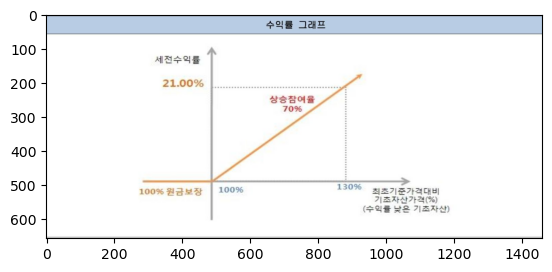

이 그래프는 수익률 그래프입니다. 수평축은 기준자산가격(%)을 나타내며, 130%까지 표시되어 있습니다. 수직축은 세전수익률을 나타내며, 최대 21%까지 표시되어 있습니다. 그래프에는 두 개의 참조선이 그려져 있는데, 하나는 100% 원금보장을, 다른 하나는 상승캡 70%를 나타냅니다. 이 그래프를 통해 기준자산가격 변화에 따른 수익률 변화를 파악할 수 있습니다.

INFO:retry-bedrock-invocation:in retry(), summary_img() returned '이 그래프는 수익률 그래프입니다. 수평축은 기준자산가격(%)을 나타내며, 130%까지 표시되어 있습니다. 수직축은 세전수익률을 나타내며, 최대 21%까지 표시되어 있습니다. 그래프에는 두 개의 참조선이 그려져 있는데, 하나는 100% 원금보장을, 다른 하나는 상승캡 70%를 나타냅니다. 이 그래프를 통해 기준자산가격 변화에 따른 수익률 변화를 파악할 수 있습니다.'
INFO:retry-bedrock-invocation:trying summary_img() [1/5]



==
0


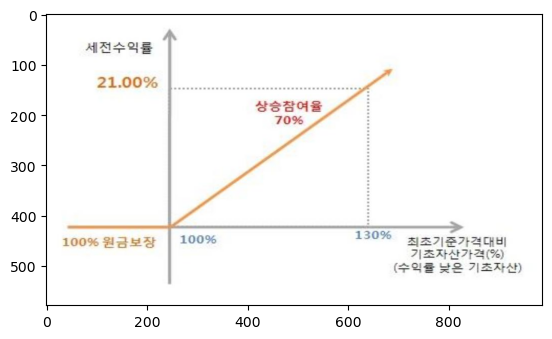

이 이미지는 생산곡선 그래프를 보여주고 있습니다. 완전 고용 수준에서 잠재적 생산 능력을 100%로 표시하고, 실제 경제 운영 시 생산 갭이 발생하여 실제 생산량이 70%로 떨어진 상황을 나타냅니다. 경기 확장 정책을 통해 130%까지 생산을 늘릴 수 있다는 것을 보여주고 있습니다. 개념적으로 단기적인 총수요 관리 정책의 효과를 설명하는 그래프라고 볼 수 있습니다.

INFO:retry-bedrock-invocation:in retry(), summary_img() returned '이 이미지는 생산곡선 그래프를 보여주고 있습니다. 완전 고용 수준에서 잠재적 생산 능력을 100%로 표시하고, 실제 경제 운영 시 생산 갭이 발생하여 실제 생산량이 70%로 떨어진 상황을 나타냅니다. 경기 확장 정책을 통해 130%까지 생산을 늘릴 수 있다는 것을 보여주고 있습니다. 개념적으로 단기적인 총수요 관리 정책의 효과를 설명하는 그래프라고 볼 수 있습니다.'
INFO:retry-bedrock-invocation:trying summary_img() [1/5]



==
1


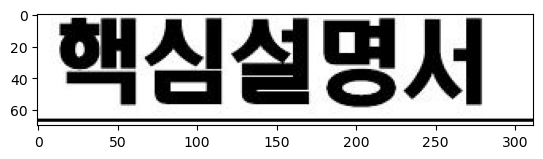

제공된 이미지는 굵은 검은색 글씨로 "핵심설명서"라는 텍스트가 포함되어 있습니다. 이는 어떤 문서나 자료의 제목 또는 표제일 것으로 보입니다. 간결하고 명확한 제목이지만 구체적인 내용은 알 수 없습니다.

INFO:retry-bedrock-invocation:in retry(), summary_img() returned '제공된 이미지는 굵은 검은색 글씨로 "핵심설명서"라는 텍스트가 포함되어 있습니다. 이는 어떤 문서나 자료의 제목 또는 표제일 것으로 보입니다. 간결하고 명확한 제목이지만 구체적인 내용은 알 수 없습니다.'



==
2


In [41]:
image_summaries = []
for idx, img_base64 in enumerate(img_info):
    summary = summary_img(summarize_chain, img_base64)
    image_summaries.append(summary)
    print ("\n==")
    print (idx)
    
#image_summaries = summarize_chain.batch(img_info, config={"max_concurrency": 1})

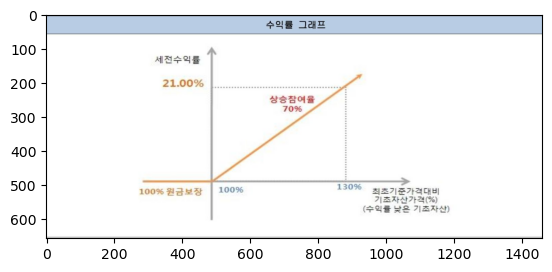

Summary: 이 그래프는 수익률 그래프입니다. 수평축은 기준자산가격(%)을 나타내며, 130%까지 표시되어 있습니다. 수직축은 세전수익률을 나타내며, 최대 21%까지 표시되어 있습니다. 그래프에는 두 개의 참조선이 그려져 있는데, 하나는 100% 원금보장을, 다른 하나는 상승캡 70%를 나타냅니다. 이 그래프를 통해 기준자산가격 변화에 따른 수익률 변화를 파악할 수 있습니다.


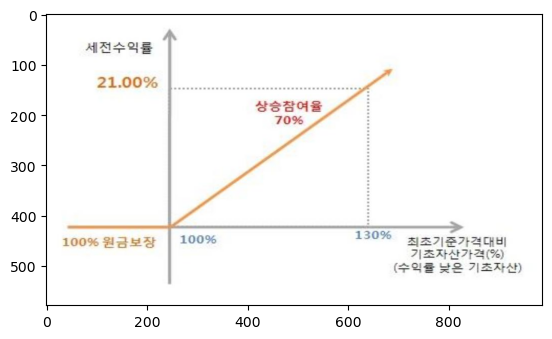

Summary: 이 이미지는 생산곡선 그래프를 보여주고 있습니다. 완전 고용 수준에서 잠재적 생산 능력을 100%로 표시하고, 실제 경제 운영 시 생산 갭이 발생하여 실제 생산량이 70%로 떨어진 상황을 나타냅니다. 경기 확장 정책을 통해 130%까지 생산을 늘릴 수 있다는 것을 보여주고 있습니다. 개념적으로 단기적인 총수요 관리 정책의 효과를 설명하는 그래프라고 볼 수 있습니다.


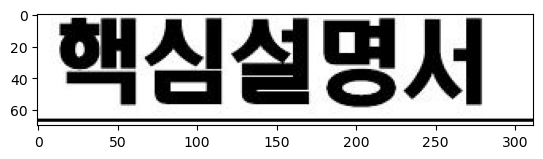

Summary: 제공된 이미지는 굵은 검은색 글씨로 "핵심설명서"라는 텍스트가 포함되어 있습니다. 이는 어떤 문서나 자료의 제목 또는 표제일 것으로 보입니다. 간결하고 명확한 제목이지만 구체적인 내용은 알 수 없습니다.


In [42]:
verbose = True
if verbose:
    for img_base64, summary in zip(img_info, image_summaries):

        print ("============================")
        img = Image.open(BytesIO(base64.b64decode(img_base64)))
        plt.imshow(img)
        plt.show()

        print (f'Summary: {summary}')

`요약`된 내용을 Document의 `page_content`로, `OCR`결과는 metadata의 `origin_image`로 사용

In [43]:
images_preprocessed = []

for img_path, image_base64, summary in zip(images, img_info, image_summaries):
    
    metadata = {}
    metadata["img_path"] = img_path
    metadata["category"] = "Image"
    metadata["image_base64"] = image_base64
    
    doc = Document(
        page_content=summary,
        metadata=metadata
    )
    images_preprocessed.append(doc)

### For tables

In [44]:
human_prompt = [
    {
        "type": "text",
        "text": '''
                 Here is the table: <table>{table}</table>
                 Given table, give a concise summary.
                 Don't insert any XML tag such as <table> and </table> when answering.
                 Write in Korean.
        '''
    },
]
human_message_template = HumanMessagePromptTemplate.from_template(human_prompt)

In [45]:
prompt = ChatPromptTemplate.from_messages(
    [
        system_message_template,
        human_message_template
    ]
)

#summarize_chain = prompt | llm_text | StrOutputParser()
summarize_chain = {"table": lambda x:x} | prompt | llm_text | StrOutputParser()

In [46]:
if table_by_llama_parse and table_by_pymupdf:
    tables = tables + docs_table_llamaparse + docs_table_pymupdf
elif table_by_llama_parse:
    tables = tables + docs_table_llamaparse
elif table_by_pymupdf:
    tables = tables + docs_table_pymupdf

In [47]:
table_info = [(t.page_content, t.metadata["text_as_html"]) for t in tables]
table_summaries = summarize_chain.batch(table_info, config={"max_concurrency": 1})
if table_as_image: table_info = [(t.page_content, t.metadata["text_as_html"], t.metadata["image_base64"]) if "image_base64" in t.metadata else (t.page_content, t.metadata["text_as_html"], None) for t in tables]

이 표는 만기상환금액에 관한 내용을 설명하고 있습니다. 만기평가가격이 최초기준가격의 100% 이상일 경우, 만기수익률이 낮은 기초자산 기준으로 (만기평가가격-최초기준가격)/최초기준가격×70%를 상환합니다. 만기평가가격이 최초기준가격의 100% 미만일 경우, 만기수익률이 낮은 기초자산 기준으로 총액면금액의 100%를 상환합니다.이 표는 코스피200 지수와 달러 환율의 변동에 따른 수익률과 손익을 보여주고 있습니다. 최초 기준가격 결정일에는 코스피200 지수가 250pt, 달러 환율이 1,500원이었습니다. 만기평가일 1에는 코스피200 지수가 20% 상승하고 달러 환율도 10% 상승하여 7.0%의 수익률과 700만원의 세전 손익이 발생했습니다. 반면 만기평가일 2에는 코스피200 지수는 20% 상승했지만 달러 환율이 10% 하락하여 수익률과 손익이 빈칸으로 표시되어 있습니다.

In [48]:
from utils.common_utils import print_html

0
table: 구 분 내 용 만기상환금액 ① 만기평가가격이 최초기준가격의 100% 이상인 경우 (만기수 만기 익률이 낮은 기초자산 기준) 기준가격) /최초기준가격 × 70%}] 상환 ② 만기평가가격이 최초기준가격의 100% 미만인 경우 (만기수 익률이 낮은 기초자산 기준) 총액면금액×100%
----------------------------
summary: 이 표는 만기상환금액에 관한 내용을 설명하고 있습니다. 만기평가가격이 최초기준가격의 100% 이상일 경우, 만기수익률이 낮은 기초자산 기준으로 (만기평가가격-최초기준가격)/최초기준가격×70%를 상환합니다. 만기평가가격이 최초기준가격의 100% 미만일 경우, 만기수익률이 낮은 기초자산 기준으로 총액면금액의 100%를 상환합니다.
----------------------------
html:


만 기,,의 익 률 이 낮 은 기 초 자 산 기 준 ),,,우,,| 만 기 평 가 가 격 - 최 코 기 준 가 격 ) / 최 초 기 준 가 격 × 70%}]
상 환,|@,만 기 평 가 가 격 이 최 초 기 준 가 격 의,100% 미 만 인,,경 우 ( 만,기 수,
,,익 률 이 낮 은 기 초 자 산 기 준 ),,,,,에 액 면 금 액 ×＊100%


----------------------------
image


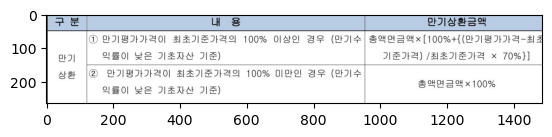

1
table: 결정일 KOSPI200 금 수익률 손익(세전) 최초기준가격결정일 250pt 1,500 달러 - - 만기평가일 1 300pt (20%상승) 1,650 달러 (10%상승) 7.0% +700 만원 만기평가일 2 300pt (20%상승) 1,350 달러 (10%하락) - -
----------------------------
summary: 이 표는 코스피200 지수와 달러 환율의 변동에 따른 수익률과 손익을 보여주고 있습니다. 최초 기준가격 결정일에는 코스피200 지수가 250pt, 달러 환율이 1,500원이었습니다. 만기평가일 1에는 코스피200 지수가 20% 상승하고 달러 환율도 10% 상승하여 7.0%의 수익률과 700만원의 세전 손익이 발생했습니다. 반면 만기평가일 2에는 코스피200 지수는 20% 상승했지만 달러 환율이 10% 하락하여 수익률과 손익이 빈칸으로 표시되어 있습니다.
----------------------------
html:


최 초기주가켜켜저이 준 가 격 결 정 일,250pt,"1,500 달 러",-,
만 기 평 가 일 1,300pt (20% 상 슴 ),"1,650 달 러 (10% 상 승 )",7.0%,+700 만 원
만 기 평 가 일 2,300pt (20% 상 승 ),"1,350 달 러 (10% 하 락 )",〉,〉


----------------------------
image


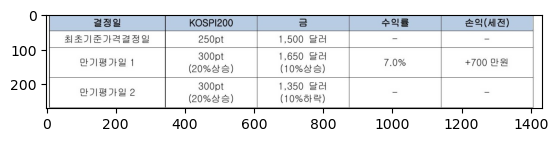

In [49]:
verbose = True
index = 0
if verbose:
    for table, summary in zip(table_info, table_summaries):

        if table_as_image:
            page_contents, table_as_html, img_base64 = table
        else: page_contents, table_as_html = table

        print ("============================")
        print (index)
        print (f'table: {page_contents}')
        print ("----------------------------")
        print (f'summary: {summary}')
        print ("----------------------------")
        print (f'html:')
        print_html(table_as_html)
        print ("----------------------------")
        if table_as_image and img_base64 is not None:
            print ("image")
            img = Image.open(BytesIO(base64.b64decode(img_base64)))
            plt.imshow(img)
            plt.show()
        index += 1


`요약`된 내용을 Document의 `page_content`로, `parsed table`은 metadata의 `origin_table`로 사용

In [50]:
tables_preprocessed = []

for origin, summary in zip(tables, table_summaries):
    metadata = origin.metadata
    metadata["origin_table"] = origin.page_content
    doc = Document(
        page_content=summary,
        metadata=metadata
    )
    tables_preprocessed.append(doc)
    
#tables_preprocessed, images_preprocessed


In [51]:
#to_pickle(tables_preprocessed, "./data/complex_pdf/pickle/tables_preprocessed.pkl")
#to_pickle(images_preprocessed, "./data/complex_pdf/pickle/images_preprocessed.pkl")
#docs = load_pickle("./data/complex_pdf/pickle/parsed_unstructured.pkl")

In [52]:
#tables_preprocessed = load_pickle("./data/complex_pdf/pickle/tables_preprocessed.pkl")
#images_preprocessed = load_pickle("./data/complex_pdf/pickle/images_preprocessed.pkl")

## 4. Index 생성

### Index 이름 결정

In [53]:
import boto3
from utils.ssm import parameter_store

In [54]:
region=boto3.Session().region_name
pm = parameter_store(region)

In [55]:
#index_name = "kb_complex_doc"
#index_name = "summit-workshop-index" #summit-workshop-index-unstructured, #summit-workshop-index-unstructured-pymupdf, summit-workshop-index-unstructured-pymupdf-llama
index_name = "customer_doc_index"

In [56]:
pm.put_params(
    key="opensearch_index_name",
    value=f'{index_name}',
    overwrite=True,
    enc=False
)

Parameter stored successfully.


### Index 스키마 정의

In [57]:
index_body = {
    'settings': {
        'analysis': {
            'analyzer': {
                'my_analyzer': {
                         'char_filter':['html_strip'],
                    'tokenizer': 'nori',
                    'filter': [
                        #'nori_number',
                        #'lowercase',
                        #'trim',
                        'my_nori_part_of_speech'
                    ],
                    'type': 'custom'
                }
            },
            'tokenizer': {
                'nori': {
                    'decompound_mode': 'mixed',
                    'discard_punctuation': 'true',
                    'type': 'nori_tokenizer'
                }
            },
            "filter": {
                "my_nori_part_of_speech": {
                    "type": "nori_part_of_speech",
                    "stoptags": [
                        "J", "XSV", "E", "IC","MAJ","NNB",
                        "SP", "SSC", "SSO",
                        "SC","SE","XSN","XSV",
                        "UNA","NA","VCP","VSV",
                        "VX"
                    ]
                }
            }
        },
        'index': {
            'knn': True,
            'knn.space_type': 'cosinesimil'  # Example space type
        }
    },
    'mappings': {
        'properties': {
            'metadata': {
                'properties': {
                    'source': {'type': 'keyword'},
                    'page_number': {'type':'long'},
                    'category': {'type':'text'},
                    'file_directory': {'type':'text'},
                    'last_modified': {'type': 'text'},
                    'type': {'type': 'keyword'},
                    'image_base64': {'type':'text'},
                    'origin_image': {'type':'text'},
                    'origin_table': {'type':'text'},
                }
            },
            'text': {
                'analyzer': 'my_analyzer',
                'search_analyzer': 'my_analyzer',
                'type': 'text'
            },
            'vector_field': {
                'type': 'knn_vector',
                'dimension': f"{dimension}" # Replace with your vector dimension
            }
        }
    }
}


## 5. LangChain OpenSearch VectorStore 생성 
### 선수 조건

#### [중요] 아래에 aws parameter store 에 아래 인증정보가 먼저 입력되어 있어야 합니다.

In [58]:
opensearch_domain_endpoint = pm.get_params(
    key="opensearch_domain_endpoint",
    enc=False
)

opensearch_user_id = pm.get_params(
    key="opensearch_user_id",
    enc=False
)

#opensearch_user_password = pm.get_params(
#    key="opensearch_user_password",
#    enc=True
#)

In [1]:
secrets_manager = boto3.client('secretsmanager')

response = secrets_manager.get_secret_value(
    SecretId='opensearch_user_password'
)

secrets_string = response.get('SecretString')
secrets_dict = eval(secrets_string)
#opensearch_user_password= list(secrets_dict.values())[0]

opensearch_user_password = secret_string['pwkey']

NameError: name 'boto3' is not defined

In [60]:
opensearch_domain_endpoint = opensearch_domain_endpoint
rag_user_name = opensearch_user_id
rag_user_password = opensearch_user_password

http_auth = (rag_user_name, rag_user_password) # Master username, Master password

### OpenSearch Client 생성

In [61]:
from utils.opensearch import opensearch_utils

In [62]:
aws_region = os.environ.get("AWS_DEFAULT_REGION", None)

os_client = opensearch_utils.create_aws_opensearch_client(
    aws_region,
    opensearch_domain_endpoint,
    http_auth
)

### 오픈 서치 인덱스 생성 
- 오픈 서치에 해당 인덱스가 존재하면, 삭제 합니다. 

In [63]:
index_exists = opensearch_utils.check_if_index_exists(
    os_client,
    index_name
)

if index_exists:
    opensearch_utils.delete_index(
        os_client,
        index_name
    )

opensearch_utils.create_index(os_client, index_name, index_body)
index_info = os_client.indices.get(index=index_name)
print("Index is created")
pprint(index_info)

index_name=customer_doc_index, exists=False

Creating index:
{'acknowledged': True, 'shards_acknowledged': True, 'index': 'customer_doc_index'}
Index is created
{'customer_doc_index': {'aliases': {},
                        'mappings': {'properties': {'metadata': {'properties': {'category': {'type': 'text'},
                                                                                'file_directory': {'type': 'text'},
                                                                                'image_base64': {'type': 'text'},
                                                                                'last_modified': {'type': 'text'},
                                                                                'origin_image': {'type': 'text'},
                                                                                'origin_table': {'type': 'text'},
                                                                                'page_number': {'type': 'long'},
    

### 랭체인 인덱스 연결 오브젝트 생성

- [langchain.vectorstores.opensearch_vector_search.OpenSearchVectorSearch](https://api.python.langchain.com/en/latest/vectorstores/langchain.vectorstores.opensearch_vector_search.OpenSearchVectorSearch.html)

In [64]:
from langchain.vectorstores import OpenSearchVectorSearch

In [65]:
vector_db = OpenSearchVectorSearch(
    index_name=index_name,
    opensearch_url=opensearch_domain_endpoint,
    embedding_function=llm_emb,
    http_auth=http_auth, # http_auth
    is_aoss=False,
    engine="faiss",
    space_type="l2",
    bulk_size=100000,
    timeout=60
)
vector_db

### Chunking Strategy: Parent documents
* Chunk Size and Chunk Overlap Size

In [66]:
from utils.chunk import parant_documents

In [67]:
parent_chunk_size = 4096
parent_chunk_overlap = 0

child_chunk_size = 1024
child_chunk_overlap = 256

opensearch_parent_key_name = "parent_id"
opensearch_family_tree_key_name = "family_tree"

* Parent Chunking
    - create_parent_chunk() 아래와 같은 작업을 합니다.
    - all_docs 에 있는 문서를 parent_chunk_size 만큼으로 청킹 합니다.
    - Parent Chunk 에 두개의 메타 데이타를 생성 합니다.
        - family_tree: parent
        - parent_id : None

In [68]:
parent_chunk_docs = parant_documents.create_parent_chunk(
    docs=texts,
    parent_id_key=opensearch_parent_key_name,
    family_tree_id_key=opensearch_family_tree_key_name,
    parent_chunk_size=parent_chunk_size,
    parent_chunk_overlap=parent_chunk_overlap
)
print(f'Number of parent_chunk_docs= {len(parent_chunk_docs)}')

Number of parent_chunk_docs= 3


* Insert doc into OpenSearch 

In [69]:
%%time

parent_ids = vector_db.add_documents(
    documents = parent_chunk_docs, 
    vector_field = "vector_field",
    bulk_size = 1000000
)

CPU times: user 30.1 ms, sys: 3.88 ms, total: 34 ms
Wall time: 791 ms


In [70]:
total_count_docs = opensearch_utils.get_count(os_client, index_name)
print("total count docs: ", total_count_docs)

total count docs:  {'count': 3, '_shards': {'total': 5, 'successful': 5, 'skipped': 0, 'failed': 0}}


* 삽입된 Parent Chunk 의 첫번째를 확인 합니다. family_tree, parent_id 의 값을 확인 하세요.

In [71]:
def show_opensearch_doc_info(response):
    print("opensearch document id:" , response["_id"])
    print("family_tree:" , response["_source"]["metadata"]["family_tree"])
    print("parent document id:" , response["_source"]["metadata"]["parent_id"])
    print("parent document text: \n" , response["_source"]["text"])

response = opensearch_utils.get_document(os_client, doc_id = parent_ids[0], index_name = index_name)
show_opensearch_doc_info(response)

opensearch document id: 8a501e99-d80f-4c79-80e2-32b10808c45d
family_tree: parent
parent document id: None
parent document text: 
 이 설명서는 금융소비자의 권익 보호 및 금융상품에 대한 이해 증진을 위하여 금융상품의 핵심내용을 쉽게 이해하실 수 있도록 작성한 것입니다. 상품내용을 충분히 이해하신 다음에 청약여부를 결정하시기 바랍니다. 핵심설명서 [미래에셋증권 제 253 회 파생결합증권(DLS)(원금보장형)] 1] 1 상품 개요 | ○ 모집가액: 100 억원 (모집된 금액이 10 억 미만일 경우 발행이 취소될 수 있음) ○ 기초자산: KOSPI200 지수(블룸버그 Ticker: KOSPI2 index), 금가격지수 (블룸버그 Ticker: GOLDLNPM index) ○ 청약기간 : 2011 년 07 월 04 일 ~2011 년 07 월 07 일 16 시 ○ 청약단위 : 100 만원 이상 100 만원 단위 (발행 후 추가 납입 불가) ○ 발 행 일 : 2011 년 07 월 08 일 ○ 만 기 일 : 2012 년 07 월 09 일(만기 1 년) ○ 상품위험등급: 4 등급 2 기준가격 결정일 및 평가방법 ○ 최초 기준가격: 2011 년 07 월 07 일의 종가(해당 거래소 기준) ○ 만기 평가가격: 2012 년 07 월 03 일의 종가(해당 거래소 기준) 3| 3 손익 구조 l


* Child Chunking
    - 아래의 create_child_chunk() 는 다음과 같은 작업을 합니다.
    - parent_chunk_docs 각각에 대해서 Child Chunk 를 생성 합니다. 
    - Child Chunk 에 두개의 메타 데이타를 생성 합니다.
        - family_tree: child
        - parent_id : parent 에 대한 OpenSearch document id

In [72]:
# child_chunk_docs = create_child_chunk(parent_chunk_docs[0:1], parent_ids)
child_chunk_docs = parant_documents.create_child_chunk(
    child_chunk_size=child_chunk_size,
    child_chunk_overlap=child_chunk_overlap,
    docs=parent_chunk_docs,
    parent_ids_value=parent_ids,
    parent_id_key=opensearch_parent_key_name,
    family_tree_id_key=opensearch_family_tree_key_name
)

print(f"Number of child_chunk_docs= {len(child_chunk_docs)}")

Number of child_chunk_docs= 5


In [73]:
parent_id = child_chunk_docs[0].metadata["parent_id"]
print("child's parent_id: ", parent_id)
print("\n###### Search parent in OpenSearch")
response = opensearch_utils.get_document(os_client, doc_id = parent_id, index_name = index_name)
show_opensearch_doc_info(response)    

child's parent_id:  8a501e99-d80f-4c79-80e2-32b10808c45d

###### Search parent in OpenSearch
opensearch document id: 8a501e99-d80f-4c79-80e2-32b10808c45d
family_tree: parent
parent document id: None
parent document text: 
 이 설명서는 금융소비자의 권익 보호 및 금융상품에 대한 이해 증진을 위하여 금융상품의 핵심내용을 쉽게 이해하실 수 있도록 작성한 것입니다. 상품내용을 충분히 이해하신 다음에 청약여부를 결정하시기 바랍니다. 핵심설명서 [미래에셋증권 제 253 회 파생결합증권(DLS)(원금보장형)] 1] 1 상품 개요 | ○ 모집가액: 100 억원 (모집된 금액이 10 억 미만일 경우 발행이 취소될 수 있음) ○ 기초자산: KOSPI200 지수(블룸버그 Ticker: KOSPI2 index), 금가격지수 (블룸버그 Ticker: GOLDLNPM index) ○ 청약기간 : 2011 년 07 월 04 일 ~2011 년 07 월 07 일 16 시 ○ 청약단위 : 100 만원 이상 100 만원 단위 (발행 후 추가 납입 불가) ○ 발 행 일 : 2011 년 07 월 08 일 ○ 만 기 일 : 2012 년 07 월 09 일(만기 1 년) ○ 상품위험등급: 4 등급 2 기준가격 결정일 및 평가방법 ○ 최초 기준가격: 2011 년 07 월 07 일의 종가(해당 거래소 기준) ○ 만기 평가가격: 2012 년 07 월 03 일의 종가(해당 거래소 기준) 3| 3 손익 구조 l


In [74]:
child_chunk_docs[0]

Document(page_content='이 설명서는 금융소비자의 권익 보호 및 금융상품에 대한 이해 증진을 위하여 금융상품의 핵심내용을 쉽게 이해하실 수 있도록 작성한 것입니다. 상품내용을 충분히 이해하신 다음에 청약여부를 결정하시기 바랍니다. 핵심설명서 [미래에셋증권 제 253 회 파생결합증권(DLS)(원금보장형)] 1] 1 상품 개요 | ○ 모집가액: 100 억원 (모집된 금액이 10 억 미만일 경우 발행이 취소될 수 있음) ○ 기초자산: KOSPI200 지수(블룸버그 Ticker: KOSPI2 index), 금가격지수 (블룸버그 Ticker: GOLDLNPM index) ○ 청약기간 : 2011 년 07 월 04 일 ~2011 년 07 월 07 일 16 시 ○ 청약단위 : 100 만원 이상 100 만원 단위 (발행 후 추가 납입 불가) ○ 발 행 일 : 2011 년 07 월 08 일 ○ 만 기 일 : 2012 년 07 월 09 일(만기 1 년) ○ 상품위험등급: 4 등급 2 기준가격 결정일 및 평가방법 ○ 최초 기준가격: 2011 년 07 월 07 일의 종가(해당 거래소 기준) ○ 만기 평가가격: 2012 년 07 월 03 일의 종가(해당 거래소 기준) 3| 3 손익 구조 l', metadata={'source': './data/complex_pdf/sample.pdf', 'filetype': 'application/pdf', 'languages': ['kor', 'eng'], 'last_modified': '2024-06-19T14:52:47', 'page_number': 1, 'orig_elements': 'eJzNWllvI7kR/isNPdmAR+FVPPy8QDDI7O4AM3nyDgyeHmVtybDlZCab5LeniuyWdXkjK+nIBmyrikU2u46vqkhd/TbJt/kuz5fXszS57CYxucSDdE5nx5IoKjrGgwreZq0Nd5OLbnKXlz75pUf53yZxsXhIs7lf5sdK3/rvi6fl9dc8u/m6RI6Q0uGcnv23WV

### Manipulate table and image for parent documents
- set family_tree of table and image documents as "parent_table" and these kinds of types are included in searcable list (child, parent_table and parent_image) in parant document strategy.

In [75]:
for table in tables_preprocessed:
    table.metadata["family_tree"], table.metadata["parent_id"] = "parent_table", "NA"

In [76]:
for image in images_preprocessed:
    image.metadata["family_tree"], image.metadata["parent_id"] = "parent_image", "NA"

### Merge text, table and image

In [77]:
from itertools import chain

In [78]:
docs_preprocessed = list(chain(child_chunk_docs, tables_preprocessed, images_preprocessed))

In [79]:
docs_preprocessed = list(chain(images_preprocessed))

In [80]:
images_preprocessed[0]

Document(page_content='이 그래프는 수익률 그래프입니다. 수평축은 기준자산가격(%)을 나타내며, 130%까지 표시되어 있습니다. 수직축은 세전수익률을 나타내며, 최대 21%까지 표시되어 있습니다. 그래프에는 두 개의 참조선이 그려져 있는데, 하나는 100% 원금보장을, 다른 하나는 상승캡 70%를 나타냅니다. 이 그래프를 통해 기준자산가격 변화에 따른 수익률 변화를 파악할 수 있습니다.', metadata={'img_path': './fig/figure-3-2.jpg', 'category': 'Image', 'image_base64': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAKRBbUDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1

* Insert doc into OpenSearch

In [81]:
%%time

child_ids = vector_db.add_documents(
    documents=docs_preprocessed, 
    vector_field = "vector_field",
    bulk_size=1000000
)

print("length of child_ids: ", len(child_ids))

length of child_ids:  3
CPU times: user 9.08 ms, sys: 4.12 ms, total: 13.2 ms
Wall time: 715 ms


## 6. 검색 테스트

In [82]:
from utils.rag import qa_chain
from utils.rag import prompt_repo, show_context_used
from langchain.callbacks.tracers import ConsoleCallbackHandler
from utils.rag import retriever_utils, OpenSearchHybridSearchRetriever

In [83]:
opensearch_hybrid_retriever = OpenSearchHybridSearchRetriever(
    os_client=os_client,
    index_name=index_name,
    llm_text=llm_text, # llm for query augmentation in both rag_fusion and HyDE
    llm_emb=llm_emb, # Used in semantic search based on opensearch 

    # hybird-search debugger
    #hybrid_search_debugger = "semantic", #[semantic, lexical, None]
    
    # option for lexical
    minimum_should_match=0,
    filter=[],

    # option for search
    fusion_algorithm="RRF", # ["RRF", "simple_weighted"], rank fusion 방식 정의
    ensemble_weights=[.51, .49], # [for semantic, for lexical], Semantic, Lexical search 결과에 대한 최종 반영 비율 정의
    reranker=False, # enable reranker with reranker model
    #reranker_endpoint_name=endpoint_name, # endpoint name for reranking model
    parent_document=True, # enable parent document
    
    # option for complex pdf consisting of text, table and image
    complex_doc=True,
    
    # option for async search
    async_mode=True,

    # option for output
    k=7, # 최종 Document 수 정의
    verbose=False,

)

### 하이브리드 검색

In [84]:
%%time
#query = "수익률 그래프 설명해줘"
#query = "만기상환금액 알려줘"
#query = "교육목표 알려줘"
#query = "웹하드 사용법을 알려줘"
query = "생성형 AI 사용할 때 주의해야 될 점을 알려줘."
search_hybrid_result, tables, images = opensearch_hybrid_retriever.get_relevant_documents(query)
#show_context_used(search_hybrid_result)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


CPU times: user 107 ms, sys: 24.6 ms, total: 131 ms
Wall time: 376 ms



-----------------------------------------------
1. Category: Image, Chunk: 205 Characters
-----------------------------------------------


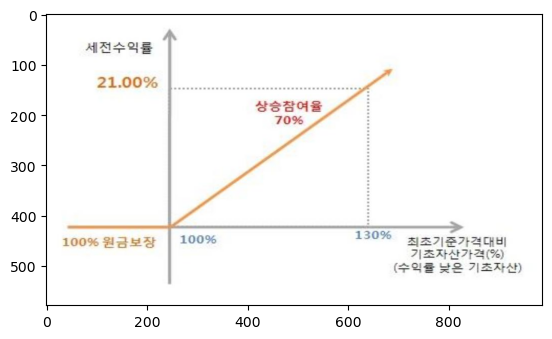

이 이미지는 생산곡선 그래프를 보여주고 있습니다. 완전 고용 수준에서 잠재적 생산 능력을 100%로 표시하고, 실제 경제 운영 시 생산 갭이 발생하여 실제 생산량이 70%로 떨어진
상황을 나타냅니다. 경기 확장 정책을 통해 130%까지 생산을 늘릴 수 있다는 것을 보여주고 있습니다. 개념적으로 단기적인 총수요 관리 정책의 효과를 설명하는 그래프라고 볼 수
있습니다.
metadata:
 {'img_path': './fig/figure-3-3.jpg', 'category': 'Image', 'image_base64': '', 'family_tree':
'parent_image', 'parent_id': 'NA', 'id': '990dd6fe-1c6d-4f62-b3af-80509112732f', 'origin_image': '',
'orig_elements': ''}

-----------------------------------------------
2. Category: Image, Chunk: 113 Characters
-----------------------------------------------


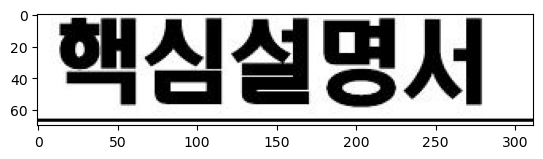

제공된 이미지는 굵은 검은색 글씨로 "핵심설명서"라는 텍스트가 포함되어 있습니다. 이는 어떤 문서나 자료의 제목 또는 표제일 것으로 보입니다. 간결하고 명확한 제목이지만 구체적인
내용은 알 수 없습니다.
metadata:
 {'img_path': './fig/figure-1-1.jpg', 'category': 'Image', 'image_base64': '', 'family_tree':
'parent_image', 'parent_id': 'NA', 'id': '3cafe8b0-385d-4ea6-8115-a050c54ef9c3', 'origin_image': '',
'orig_elements': ''}

-----------------------------------------------
3. Category: Image, Chunk: 204 Characters
-----------------------------------------------


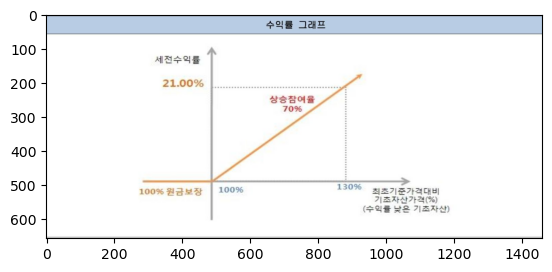

이 그래프는 수익률 그래프입니다. 수평축은 기준자산가격(%)을 나타내며, 130%까지 표시되어 있습니다. 수직축은 세전수익률을 나타내며, 최대 21%까지 표시되어 있습니다.
그래프에는 두 개의 참조선이 그려져 있는데, 하나는 100% 원금보장을, 다른 하나는 상승캡 70%를 나타냅니다. 이 그래프를 통해 기준자산가격 변화에 따른 수익률 변화를 파악할
수 있습니다.
metadata:
 {'img_path': './fig/figure-3-2.jpg', 'category': 'Image', 'image_base64': '', 'family_tree':
'parent_image', 'parent_id': 'NA', 'id': '3c3711d5-ad0b-44f6-a273-54ea4a7a11c7', 'origin_image': '',
'orig_elements': ''}


In [85]:
show_context_used(search_hybrid_result)